In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Import data
sales_train = pd.read_csv('../Data/sales_train_merge.csv', index_col = 0, parse_dates = ['date'])
sales_test = pd.read_csv('../Data/sales_test_merge.csv', index_col = 0, parse_dates = ['date'])

C:\Users\Curtis\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,2013-01-31,0,0,32,884.0,6.0,40
1,2013-01-31,0,0,33,1041.0,3.0,37
2,2013-01-31,0,0,35,247.0,1.0,40
3,2013-01-31,0,0,43,221.0,1.0,40
4,2013-01-31,0,0,51,257.0,2.0,57


In [4]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06
mean,1.466479e+01,3.280585e+01,1.068099e+04,1.625363e+03,2.267200e+00,4.154192e+01
std,9.542322e+00,1.653701e+01,6.238883e+03,5.701611e+03,8.649882e+00,1.632365e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e-02,-2.200000e+01,0.000000e+00
25%,6.000000e+00,2.100000e+01,5.045000e+03,2.490000e+02,1.000000e+00,3.000000e+01
50%,1.400000e+01,3.100000e+01,1.049700e+04,4.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.606000e+04,1.398000e+03,2.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,6.719300e+05,2.253000e+03,8.300000e+01


In [5]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609124 entries, 0 to 1609123
Data columns (total 7 columns):
date                1609124 non-null datetime64[ns]
date_block_num      1609124 non-null int64
shop_id             1609124 non-null int64
item_id             1609124 non-null int64
item_price          1609124 non-null float64
item_cnt_day        1609124 non-null float64
item_category_id    1609124 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 98.2 MB


As stated in the Data Wrangling notebook, the objective of this problem is to forecast the total amount of products sold in every shop, specifically for the provided test set. It's also noted that the list of shops and products change from month to month which needs to be accounted for. This poses a problem as we'll need to visualize which shops and items are available for which months.

# ``shop_id`` Analysis

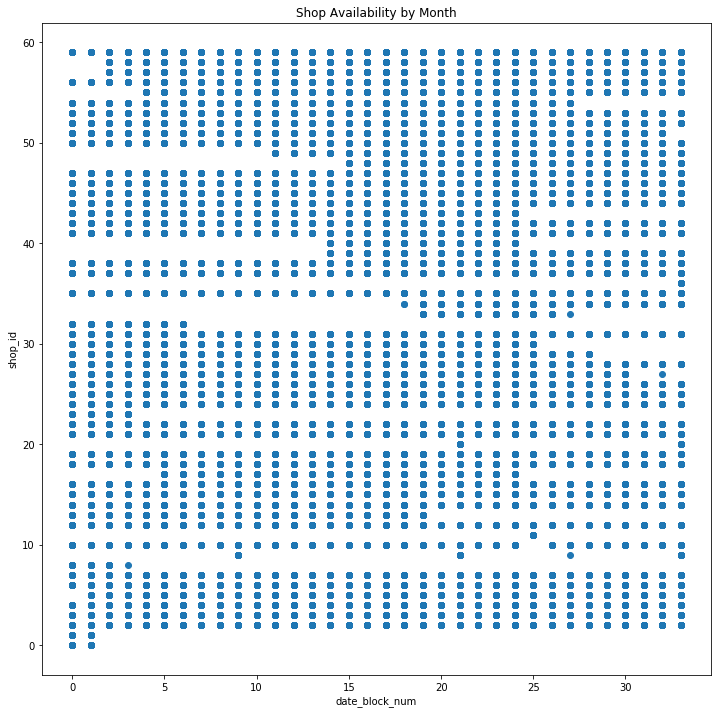

In [6]:
# Plot availability of shop_id by month
_ = plt.figure(figsize=(12,12))
_ = plt.scatter(x = 'date_block_num', y = 'shop_id', data = sales_train)
_ = plt.title('Shop Availability by Month')
_ = plt.xlabel('date_block_num')
_ = plt.ylabel('shop_id')

From the plot above, it's clear that there are a handful of shops that aren't open consistently, while ``shop_id``'s like 0, 1, and 8 haven't been open since early 2013. For purposes of this problem, it may not be necessary to predict sales from shops that aren't in the test set. This would isolate trends on those specific shops while cutting back on time, computation speed, and efficiency. If the goal of the project was to predict the future sales of all ``shop_id`` then removing the shops wouldn't be recommended.

In [7]:
# Remove shop_id not found in test set from train set
## Obtain list of shop_id in test set
test_shops = sales_test['shop_id'].unique()

## Filter out shop_id not in test_shops
sales_train_filter_shops = sales_train[sales_train['shop_id'].isin(test_shops)]

print(len(sales_train_filter_shops))
print(len(sales_train_filter_shops['shop_id'].unique()))

1323795
42


After removing the shops that don't appear in the test set, the training set has been reduced by nearly 300,000 observations (~18%) and from 59 unique ``shop_id``'s to 42. The same process could be done to the ``item_id``/``item_category_id`` column to isolate how well items or item categories tend to trend.

In [8]:
# Sum item_cnt_day in sales_train_filtered by date and shop_id
shops_grouped = sales_train_filter_shops[['date_block_num', 'item_cnt_day', 'shop_id']].groupby(['date_block_num', 'shop_id']).sum()

# Input missing values for months where shop_id's weren't open/available
## Initialize empty data frame with same multilevel index
shops_index_iter = [list(range(0,34)), test_shops]
shops_index = pd.MultiIndex.from_product(shops_index_iter, names=['date_block_num', 'shop_id'])
sales_train_shop_grouped = pd.DataFrame(index = shops_index)

# Outer merge empty data frame with shops_grouped
sales_train_shop_grouped = pd.merge(sales_train_shop_grouped, shops_grouped, how='outer',on=['date_block_num', 'shop_id']).sort_index()

# Fill NAN values with 0 indicating no sales/not open
sales_train_shop_grouped.fillna(0, inplace=True)

# Reset index
sales_train_shop_grouped.reset_index(inplace=True)

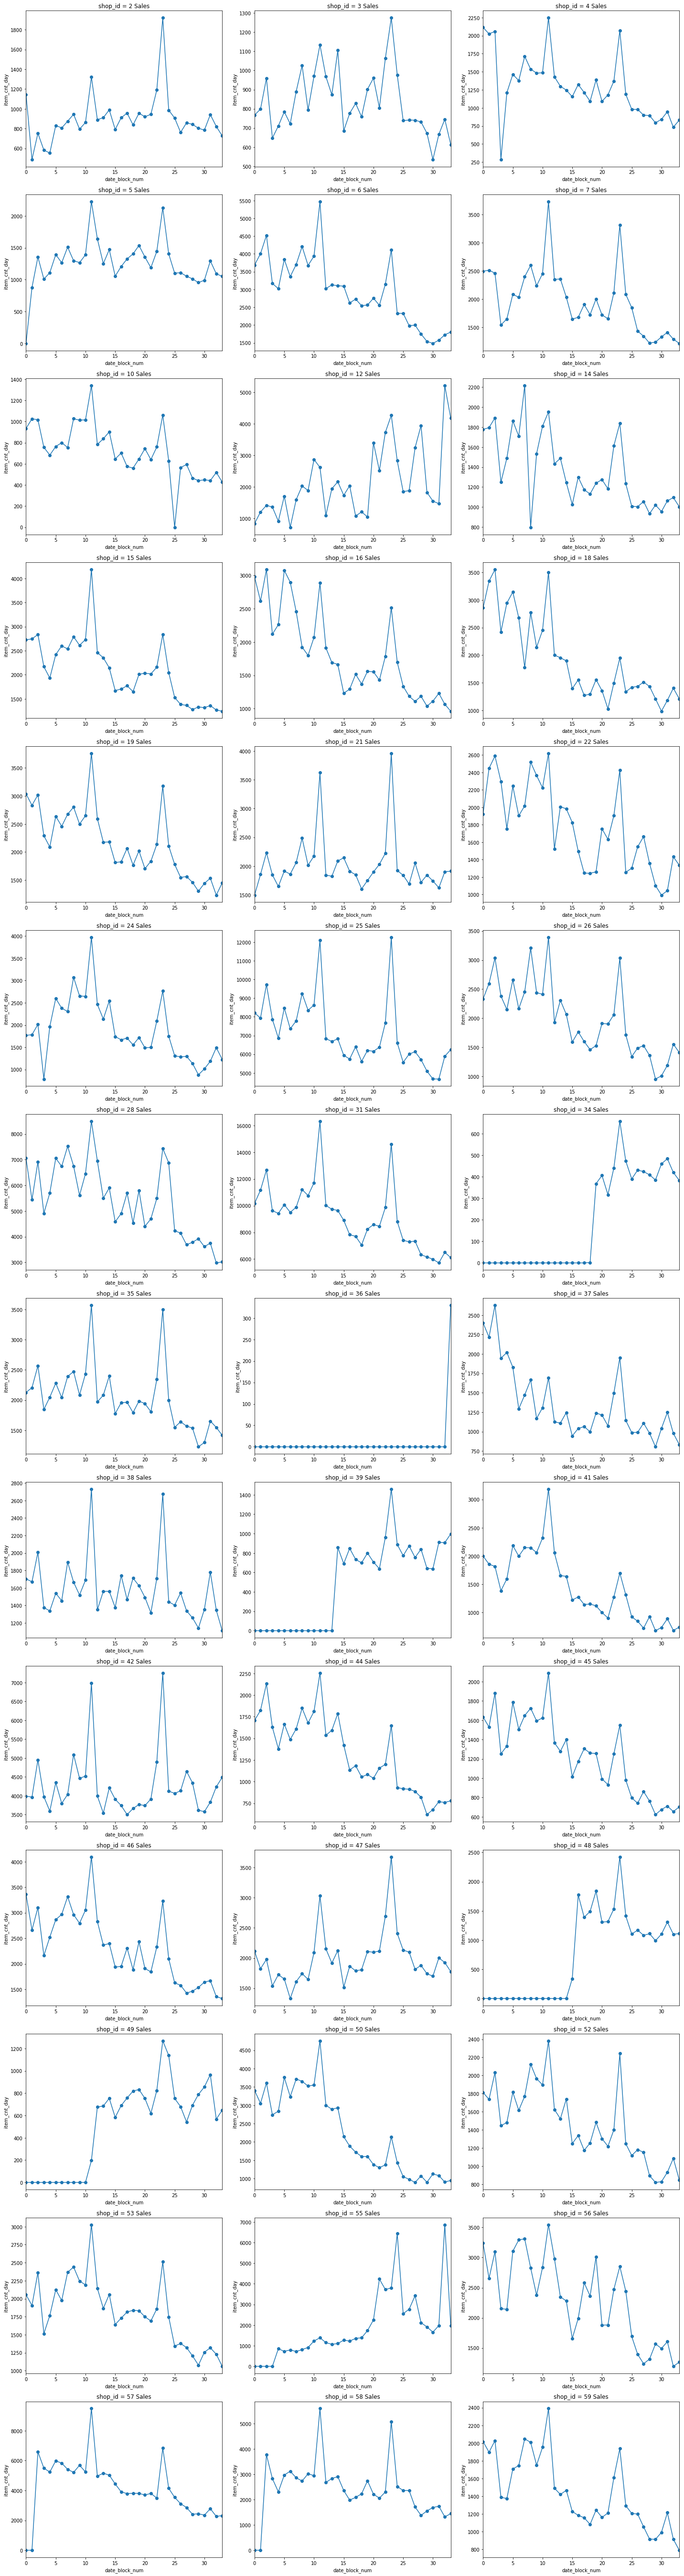

In [9]:
# Plot total item_cnt_day per date_block_num by shop_id
_ = plt.figure(figsize=(20,75))
for i in range(len(sales_train_shop_grouped['shop_id'].unique())):
    shop = sorted(sales_train_shop_grouped['shop_id'].unique())[i]
    shop_sales = sales_train_shop_grouped[sales_train_shop_grouped['shop_id'] == shop]
    
    _ = plt.subplot(14, 3, i+1)
    _ = plt.plot(shop_sales['date_block_num'], shop_sales['item_cnt_day'], marker='o')
    _ = plt.title('shop_id = %i Sales' %shop)
    _ = plt.xlabel('date_block_num')
    _ = plt.ylabel('item_cnt_day')
    _ = plt.xlim(0, 33)

_ = plt.tight_layout()

By looking at these plots, it appears that most shops have peak sales around a ``date_block_num`` of 11 and 23 which represents December is those years. One thing to pay attention to in the plots are that the scales aren't the same between shops but it's to illustrate the trends of each shop.

## ``item_category_id`` Analysis

In [10]:
# Remove item_id not found in test set from train set
## Obtain list of item_id in test set
test_item_cats = sales_test['item_category_id'].unique()

## Filter out item_id not in test_shops
sales_train_filter_cats = sales_train[sales_train['item_category_id'].isin(test_item_cats)]

print(len(sales_train_filter_cats))
print(len(sales_train_filter_cats['item_category_id'].unique()))

1592982
62


In [12]:
# Sum item_cnt_day in sales_train_filtered by date and item_category_id
cats_grouped = sales_train_filter_cats[['date_block_num', 'item_cnt_day', 'item_category_id']].groupby(['date_block_num', 'item_category_id']).sum()

# Input missing values for months where item_category_id's weren't open/available
## Initialize empty data frame with same multilevel index
cats_index_iter = [list(range(0,34)), test_item_cats]
cats_index = pd.MultiIndex.from_product(cats_index_iter, names=['date_block_num', 'item_category_id'])
sales_train_cat_grouped = pd.DataFrame(index = cats_index)

# Outer merge empty data frame with cats_grouped
sales_train_cat_grouped = pd.merge(sales_train_cat_grouped, cats_grouped, how='outer',on=['date_block_num', 'item_category_id']).sort_index()

# Fill NAN values with 0 indicating no sales/not available
sales_train_cat_grouped.fillna(0, inplace=True)

# Reset index
sales_train_cat_grouped.reset_index(inplace=True)

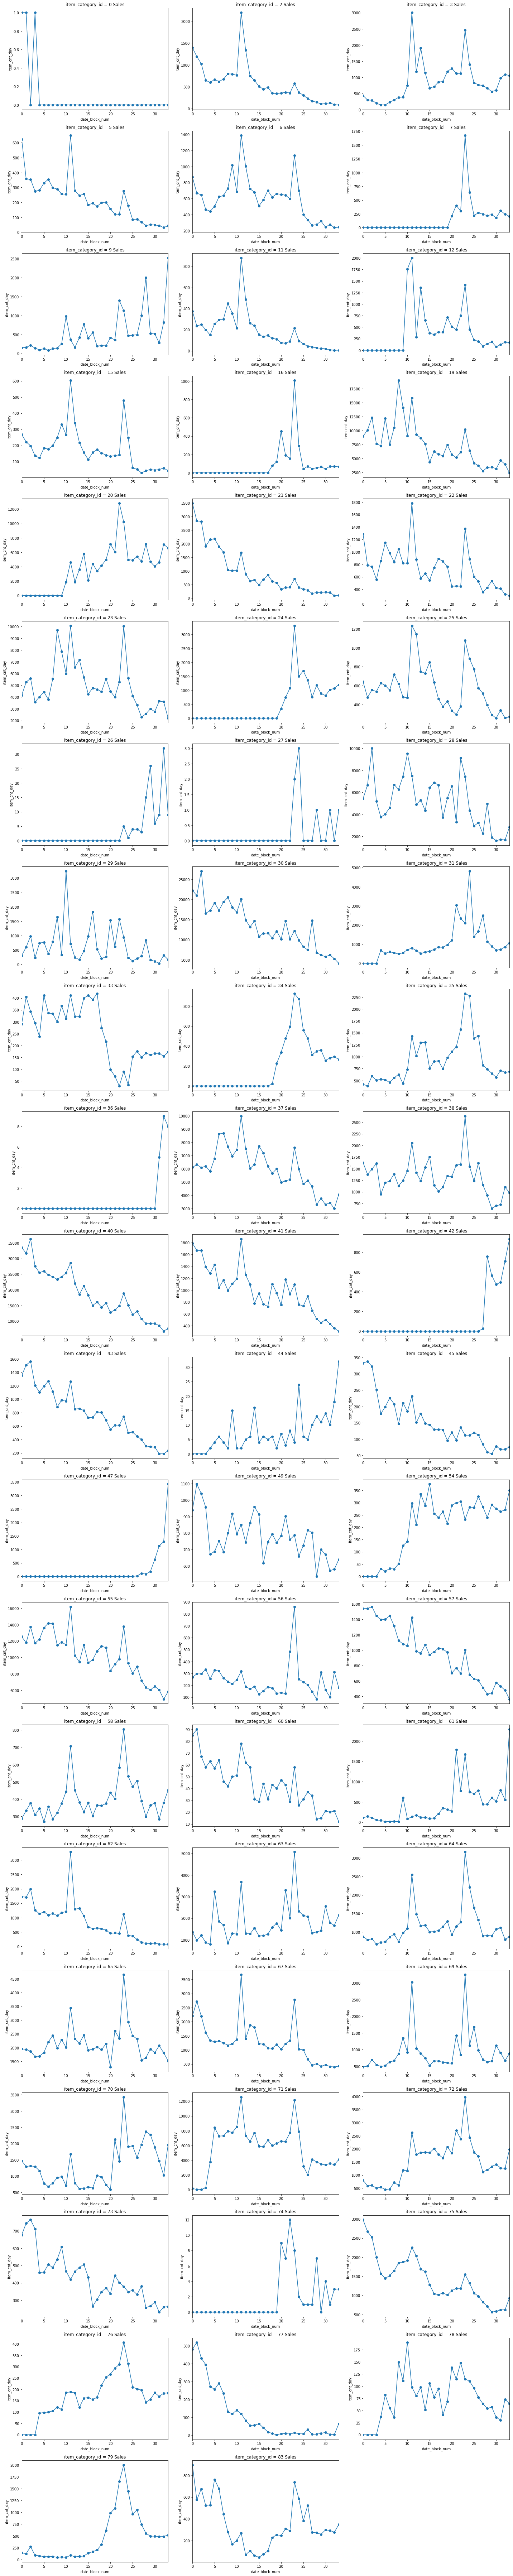

In [13]:
_ = plt.figure(figsize=(20,100))
for i in range(len(sales_train_cat_grouped['item_category_id'].unique())):
    item_cat = sorted(sales_train_cat_grouped['item_category_id'].unique())[i]
    item_cat_sales = sales_train_cat_grouped[sales_train_cat_grouped['item_category_id'] == item_cat]
    
    _ = plt.subplot(21, 3, i+1)
    _ = plt.plot(item_cat_sales['date_block_num'], item_cat_sales['item_cnt_day'], marker='o')
    _ = plt.title('item_category_id = %i Sales' %item_cat)
    _ = plt.xlabel('date_block_num')
    _ = plt.ylabel('item_cnt_day')
    _ = plt.xlim(0, 33)

_ = plt.tight_layout()

Just like when analyzing shops, there are peak times when ``item_category_id``'s tend to sell more with a few exeptional categories with underlying trends to their sales. Categories 9, 28, and 38 appear to perform randomly throughout whereas categories 44, 57, and 77 seem to have downward or upward trends. Next will be to analyze if these items statistically sell more during November/December compared to the rest of the year.

## November/December Sales

In [16]:
month_grouped = sales_train[['date', 'item_cnt_day']].groupby('date').sum()

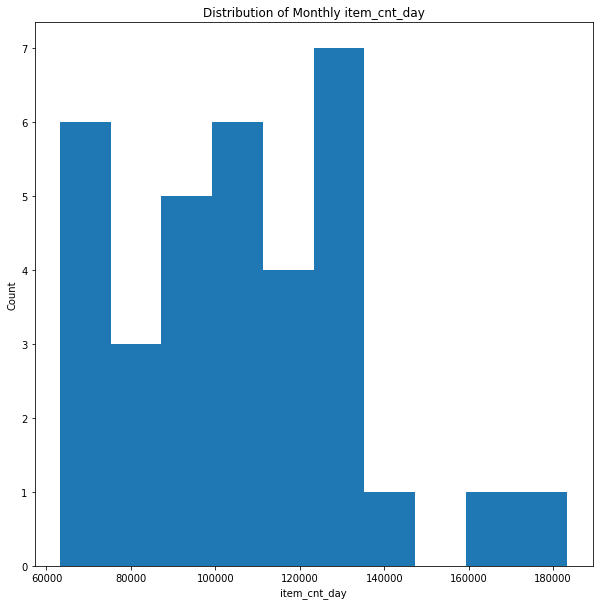

In [32]:
_ = plt.figure(figsize=(10, 10))
_ = plt.hist(month_grouped['item_cnt_day'])
_ = plt.title('Distribution of Monthly item_cnt_day')
_ = plt.xlabel('item_cnt_day')
_ = plt.ylabel('Count')

In [ ]:
# Check statistical difference between sales during off season